# Assessing the Noisy Circle Detector

In [1]:
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore') 
from pathlib import Path

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from shapely.geometry.point import Point
from skimage.draw import circle_perimeter_aa
from keras.models import load_model
from PIL import Image


plt.style.use('classic')

Using TensorFlow backend.


In [2]:
the_model = None #: global model object for convenience and caching

## Some utility functions for creating and randomizing our data

In [3]:
def draw_circle(img, row, col, rad):
    """Draw a circle into a matrix."""
    rr, cc, val = circle_perimeter_aa(row, col, rad)
    valid = (
        (rr >= 0) &
        (rr < img.shape[0]) &
        (cc >= 0) &
        (cc < img.shape[1])
    )
    img[rr[valid], cc[valid]] = val[valid]


def noisy_circle(size, radius, noise):
    """Generate a random circle for an image, and add noise."""
    img = np.zeros((size, size), dtype=np.float)
    # Circle
    row = np.random.randint(size)
    col = np.random.randint(size)
    rad = np.random.randint(10, max(10, radius))
    draw_circle(img, row, col, rad)
    # Add noise
    img += noise * np.random.rand(*img.shape)
    return (row, col, rad), img

def get_model():
    """
    Load the model as a global object
    :return: the model
    """
    MODEL_DIR = Path.cwd()
    print('model dir', MODEL_DIR)
    model_path = os.path.join(str(MODEL_DIR),
                             # "noisy.circle.detector.last.hdf5"
                             # "noisy.circle.detector.best.epoch63.hdf5"
#                             "noisy.circle.detector.best.epoch100.hdf5"
#                             "noisy.circle.detector.best.epoch27.hdf5"
                         #     "noisy.circle.detector.best.epoch34.hdf5"
#                            "noisy.circle.detector.best.epoch31.hdf5"
                               "noisy.circle.detector.best.epoch40.hdf5"
                             
                             )
    print("Loading model from ", model_path)
    global the_model
    the_model = load_model(model_path)
    return the_model

def find_circle(img):
    """
    Find the circle in the noisy image.
    param: img: a 200x200 pixel image
    returns: tuple of row, col, radius.
    """
    try:
        global the_model
        if not the_model:
            the_model = get_model()
        # normalize the data for the model
        image = (img - np.mean(img)) / np.std(img)
        results = the_model.predict(image.reshape(1, 200, 200, 1))
        row, col, rad = results[0]
        return (round(row), round(col), round(rad))
    except Exception as ex:
        print(ex) # log failure here
        print("fail!")
        return 100, 100, 30


def iou(params0, params1):
    """
    Determine intersection over union percentage. 
    Area of intersection divided by area of union
    https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    """
    row0, col0, rad0 = params0
    row1, col1, rad1 = params1
    shape0 = Point(row0, col0).buffer(rad0)
    shape1 = Point(row1, col1).buffer(rad1)
    return (shape0.intersection(shape1).area /
        shape0.union(shape1).area)

## Let's view an example of what we're searching for and the surrounding data

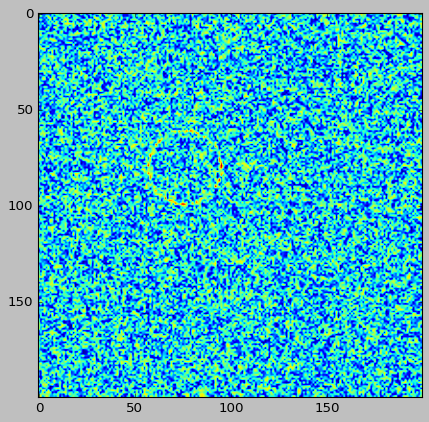

In [4]:
def show_image(an_image):
    # convert values to 0 - 255 int8 format
    formatted = (an_image * 255 / np.max(an_image)).astype('uint8')
    img = Image.fromarray(formatted)
    plt.style.use('classic')
    imshow(np.asarray(img))

params, an_image = noisy_circle(200, 50, 2)    
show_image(an_image)

In [5]:
def assess():
    results = []
    for _ in tqdm_notebook(range(1000)):
        params, img = noisy_circle(200, 50, 2)
        detected = find_circle(img)
        results.append(iou(params, detected))
    results = np.array(results)
    return results

model dir /home/todd/projects/ML-You-Can-Use/computer_vision_object_detection
Loading model from  /home/todd/projects/ML-You-Can-Use/computer_vision_object_detection/noisy.circle.detector.best.epoch40.hdf5





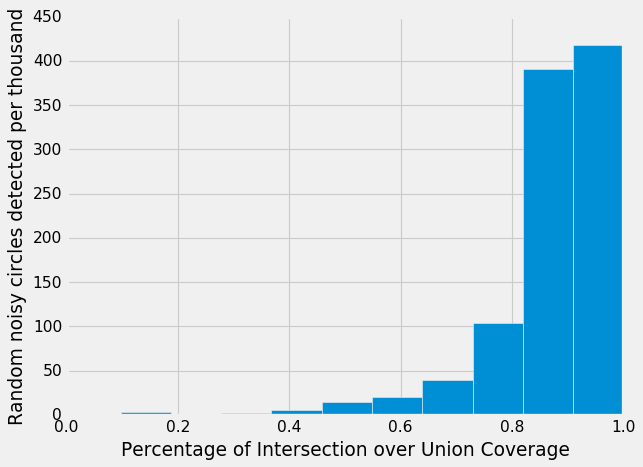

In [6]:
res = assess()
plt.style.use('fivethirtyeight')
plt.hist(res, bins=10)
plt.xlabel("Percentage of Intersection over Union Coverage")
plt.ylabel("Random noisy circles detected per thousand")
plt.show()

In [7]:
(res > 0.7).mean()

0.935